<a href="https://colab.research.google.com/github/densmyslov/bq-hackathon/blob/main/notebooks/2_data_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import pandas as pd
import requests
from io import BytesIO
from google.cloud import storage
import requests
import pytz
from datetime import datetime
import json
from typing import Dict, List, Any, Tuple, Optional
from collections import defaultdict

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import storage
gcs_client = storage.Client()


In [4]:
from google.cloud import bigquery
bq_client = bigquery.Client(project='data-science-455302')

In [5]:
bucket_name = "trump-political-ads-sample"

In [6]:
table_name = 'data-science-455302.trump_campaign_us_central1.text_docs_sample'

# BigQuery Table

In [5]:
PROJECT_ID = "data-science-455302"  # your GCP project
REGION = "us-central1"              # region of your connection / dataset
DATASET_ID = "trump_campaign_us_central1"         # dataset to store the remote model
MODEL_NAME = "mistral_medium"       # name for the remote model
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_ID = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"
BUCKET_NAME = "trump-political-ads-sample"

# Functions

In [4]:
def process_result(df):

  raw = df.iloc[0]["json_result"]

  # Strip markdown fences like ```json ... ```
  clean = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.DOTALL)

  try:
      return json.loads(clean)

  except Exception as e:
      print("❌ JSON parse error:", e)
      print("Raw output:", raw[:500])

from PIL import Image

def show_image_page(bucket_name, blob_path):
  bucket = gcs_client.bucket(bucket_name)
  blob   = bucket.blob(blob_path)

  buf = BytesIO()
  blob.download_to_file(buf)
  buf.seek(0)
  return Image.open(buf)

# Retrieve Data from Invoices

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-generate

In [8]:

endpoint = "gemini-2.5-pro"

In [10]:
prompt = """
ROLE: System
TASK: Extract structured data from a U.S. political TV/radio advertising invoice (e.g., Sinclair/WideOrbit). Return ONLY a single JSON object matching the provided schema.


SCHEMA: See `invoice_schema` (Python dict) — you must adhere to it.


NORMALIZATION:
- Dates → YYYY-MM-DD
- Times → 24h HH:MM in the station’s local time
- Currency → USD; numbers as plain decimals (no symbols, commas)
- Derivations: if a required numeric is missing but inferable, compute it (e.g., gross_line_amount = unit_price * spots)
- Missing & uninferable → null (never invent values)


CAPTURE (Summary):
- Identifiers: Invoice number/date/month; Invoice period start/end; Flight start/end; Order #; Alt order #; Estimate #; Product code
- Parties/Addresses: Issued by (+address), Issued to business (+address), Remit-to (if any)
- Station/Market: Property/Station call sign, Market/DMA/Locality
- Financials: Total amount (gross), Agency commission, Net amount due, Tax amount; Payment terms; Billing calendar/type
- Campaign: Advertiser/campaign name, candidate (if present), party, office sought, election cycle


CAPTURE (Line items): For each schedule/program row
- station, market, program_title, description
- week_start/week_end OR air_date if single date
- start_time_local and end_time_local when a range is shown; daypart if readable
- length_seconds (e.g., ":30" → 30), rate_type (e.g., NM)
- spots, spots_per_week, unit_price, gross_line_amount (compute if needed), net_line_amount (if commission allocable)
- order_number/estimate_number/ad_id when shown on the row


LAYOUT HINTS:
- Tables commonly include: Description (program), Start/End Date, Start/End Time, MTWTFSS, Length, Spots/Week, Rate, Type, Spots
- Totals are usually at the bottom: Gross Total, Agency Commission, Net Amount Due
- “Property” is station call sign (e.g., WGTU); “Advertiser” is the campaign (e.g., Donald Trump for President – R)


OUTPUT:
- Exactly one JSON object matching `invoice_schema`. No markdown, no comments, no trailing text.

"""

## test - entire pdf file

In [11]:


PROJECT_ID   = "data-science-455302"
DATASET_ID   = "trump_campaign_us_central1"
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_RESOURCE = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"


sql = f"""
WITH src AS (
  SELECT
    pdf_key,
    REPLACE(
      REPLACE(pdf_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE is_invoice = TRUE
  LIMIT 1
)
SELECT
  pdf_key,
  (
    AI.GENERATE(
      STRUCT(
        @prompt        AS prompt,
        url            AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    )
  ).result AS json_result,
  (
    AI.GENERATE(
      STRUCT(
        @prompt        AS prompt,
        url            AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    )
  ).full_response AS raw_response
FROM src
"""

job_cfg = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ScalarQueryParameter("prompt", "STRING", prompt)]
)

df = bq_client.query(sql, job_config=job_cfg).to_dataframe()
print(df.head(1))


                                             pdf_key  \
0  gs://trump-political-ads-sample/FCC/docs/75d9b...   

                                         json_result  \
0  ```json\n{\n  "invoice_number": "4637128",\n  ...   

                                        raw_response  
0  {"candidates":[{"avg_logprobs":-0.176738085143...  


In [12]:
df['pdf_key'].tolist()[0]

'gs://trump-political-ads-sample/FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/doc.pdf'

In [13]:
res = json.loads(df['raw_response'].tolist()[0])
list(res)

['candidates', 'create_time', 'model_version', 'response_id', 'usage_metadata']

In [14]:
res['usage_metadata']

{'billable_prompt_usage': {'text_count': 1882},
 'candidates_token_count': 4183,
 'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 4183}],
 'prompt_token_count': 639,
 'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 639}],
 'thoughts_token_count': 5101,
 'total_token_count': 9923,
 'traffic_type': 'ON_DEMAND'}

In [ ]:
df

,pdf_key,json_result,raw_response
0,gs://trump-political-ads-sample/FCC/docs/75d9b...,"```json\n{\n ""invoice_number"": ""4637128"",\n ...","{""candidates"":[{""avg_logprobs"":-0.176738085143..."


'FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/doc.pdf'

gs://trump-political-ads-sample/FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/doc.pdf


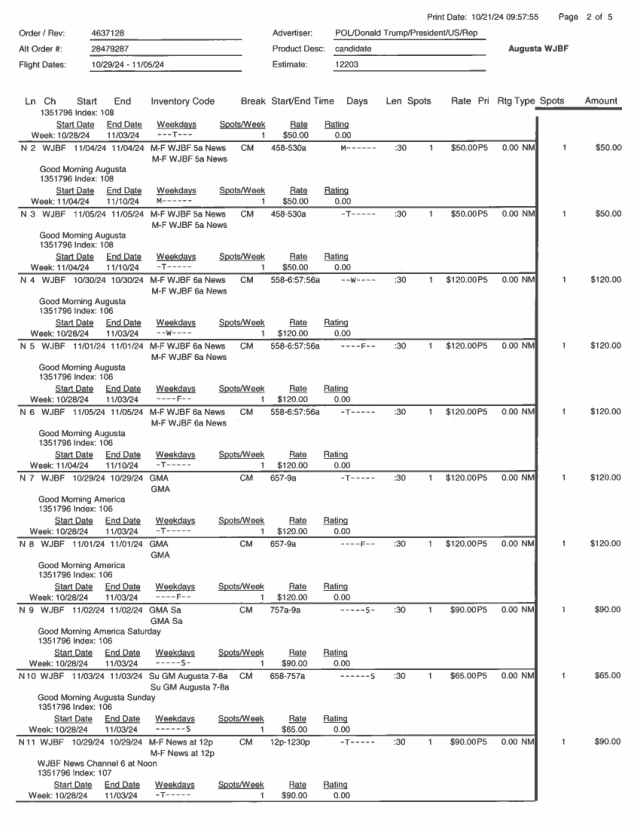

In [15]:
from PIL import Image

uri = df['pdf_key'].tolist()[0]
print(uri)
bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/page_2.png"
bucket = gcs_client.bucket(bucket_name)
blob   = bucket.blob(blob_path)

buf = BytesIO()
blob.download_to_file(buf)
buf.seek(0)
img = Image.open(buf)
img.show()          # opens in local viewer if running desktop
display(img)

In [16]:
import json
import re

raw = df.iloc[0]["json_result"]

# Strip markdown fences like ```json ... ```
clean = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.DOTALL)

try:
    parsed = json.loads(clean)
    print("✅ Parsed JSON")
    print(parsed)
except Exception as e:
    print("❌ JSON parse error:", e)
    print("Raw output:", raw[:500])


✅ Parsed JSON
{'invoice_number': '4637128', 'invoice_date': '2024-10-17', 'invoice_month': '2024-10', 'invoice_period_start': '2024-10-01', 'invoice_period_end': '2024-10-31', 'flight_start': '2024-10-16', 'flight_end': '2024-10-22', 'order_number': '4410119', 'alt_order_number': '4410119-01', 'estimate_number': '16843', 'product_code': 'TRUMP24', 'issued_by': {'name': 'WGTU/WGTQ-TV', 'address': '8518 M 72 WEST, TRAVERSE CITY, MI 49684'}, 'issued_to': {'name': 'National Media Research, Plannin', 'address': '815 Slaters Lane, Alexandria, VA 22314'}, 'remit_to': {'name': 'Sinclair Television Group, Inc.', 'address': 'P.O. BOX 105658, ATLANTA, GA 30348-5658'}, 'property': 'WGTU', 'market': 'TRAVERSE CITY-CADILLAC', 'advertiser': 'Donald J. Trump for President 2024, Inc.', 'candidate': 'Donald J. Trump', 'party': 'R', 'office_sought': 'President', 'election_cycle': '2024', 'total_amount': '2050.00', 'agency_commission': '307.50', 'net_amount': '1742.50', 'tax_amount': None, 'payment_terms'

In [17]:
parsed

{'invoice_number': '4637128',
 'invoice_date': '2024-10-17',
 'invoice_month': '2024-10',
 'invoice_period_start': '2024-10-01',
 'invoice_period_end': '2024-10-31',
 'flight_start': '2024-10-16',
 'flight_end': '2024-10-22',
 'order_number': '4410119',
 'alt_order_number': '4410119-01',
 'estimate_number': '16843',
 'product_code': 'TRUMP24',
 'issued_by': {'name': 'WGTU/WGTQ-TV',
  'address': '8518 M 72 WEST, TRAVERSE CITY, MI 49684'},
 'issued_to': {'name': 'National Media Research, Plannin',
  'address': '815 Slaters Lane, Alexandria, VA 22314'},
 'remit_to': {'name': 'Sinclair Television Group, Inc.',
  'address': 'P.O. BOX 105658, ATLANTA, GA 30348-5658'},
 'property': 'WGTU',
 'market': 'TRAVERSE CITY-CADILLAC',
 'advertiser': 'Donald J. Trump for President 2024, Inc.',
 'candidate': 'Donald J. Trump',
 'party': 'R',
 'office_sought': 'President',
 'election_cycle': '2024',
 'total_amount': '2050.00',
 'agency_commission': '307.50',
 'net_amount': '1742.50',
 'tax_amount': None,

the model hallucinated;

## test - first page image

In [18]:


# 1. Define image location and construct the GCS URI
bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/page_2.png"
image_uri   = f"gs://{bucket_name}/{blob_path}"

# 2. Simplify the SQL to directly use the image URI parameter
#    This version is also more efficient, calling the AI function only once.
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  '{image_uri}' AS image_processed,
  response.result AS json_result,
  response.full_response AS raw_response
FROM ai_call
"""

# 3. Update job_config to pass both the prompt and the new image_uri parameter
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# Execute the query
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)
# --- END MODIFIED SECTION ---

                                     image_processed  \
0  gs://trump-political-ads-sample/FCC/docs/75d9b...   

                                         json_result  \
0  ```json\n{\n  "invoice_number": "4095594",\n  ...   

                                        raw_response  
0  {"candidates":[{"avg_logprobs":-0.115803407944...  


In [19]:
res_page = json.loads(df['raw_response'].tolist()[0])
list(res_page)

['candidates', 'create_time', 'model_version', 'response_id', 'usage_metadata']

In [21]:
res_page['usage_metadata']

{'billable_prompt_usage': {'text_count': 1850},
 'candidates_token_count': 4111,
 'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 4111}],
 'prompt_token_count': 627,
 'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 627}],
 'thoughts_token_count': 4282,
 'total_token_count': 9020,
 'traffic_type': 'ON_DEMAND'}

In [23]:
raw_page = df.iloc[0]["json_result"]
# Strip markdown fences like ```json ... ```
clean_page = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw_page.strip(), flags=re.DOTALL)

try:
    parsed_page = json.loads(clean_page)

except Exception as e:
    print("❌ JSON parse error:", e)
    print("Raw output:", raw[:500])

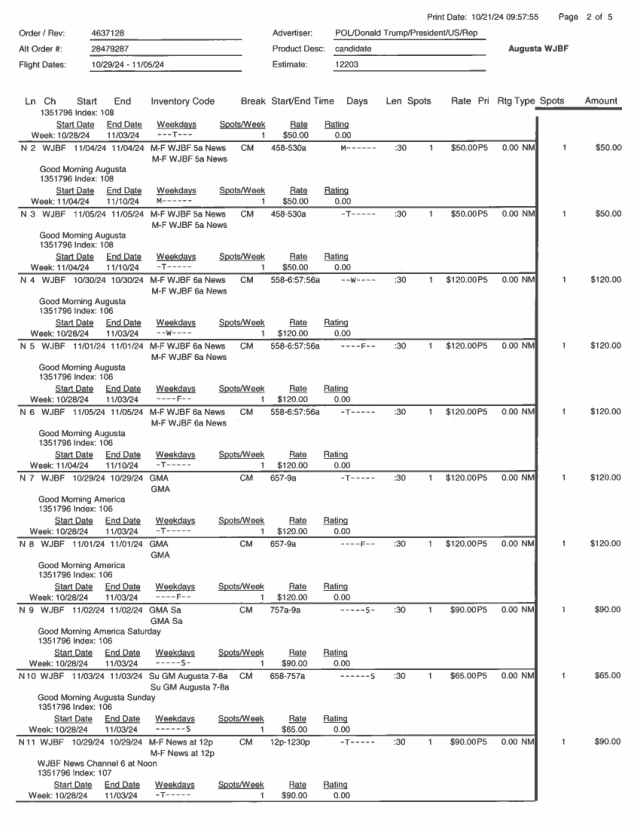

In [26]:
from PIL import Image


bucket = gcs_client.bucket(bucket_name)
blob   = bucket.blob(blob_path)

buf = BytesIO()
blob.download_to_file(buf)
buf.seek(0)
img = Image.open(buf)
img.show()          # opens in local viewer if running desktop
display(img)

In [25]:
json.loads(clean_page)

{'invoice_number': '4095594',
 'invoice_date': '2024-10-01',
 'invoice_month': 'October, 2024',
 'period_start': '2024-09-30',
 'period_end': '2024-10-06',
 'flight_start': '2024-09-30',
 'flight_end': '2024-10-06',
 'order_number': '500355465',
 'alt_order_number': None,
 'estimate_number': None,
 'product_code': 'POL/Donald J Trump for President',
 'issued_by': {'name': 'WGTU',
  'address': '851 S. Ellsworth Avenue\nTraverse City, MI 49686-4554'},
 'issued_to': {'name': 'National Media Research Plan & Placement',
  'address': '815 Slaters Lane\nAlexandria VA 22314-1175'},
 'remit_to': {'name': 'Sinclair Broadcast Group',
  'address': 'PO Box 743118\nAtlanta, GA 30374-3118'},
 'station_call_sign': 'WGTU',
 'market': 'Traverse City-Cadillac',
 'total_gross_amount': '6445.00',
 'agency_commission_amount': '966.75',
 'total_net_amount': '5478.25',
 'tax_amount': None,
 'payment_terms': 'Net 30 Days',
 'billing_calendar': 'Broadcast',
 'billing_type': 'Candidate',
 'advertiser_name': 'Don

## test - extract number of line items only

In [27]:
prompt = """
ROLE:
You are an automated data extraction system.

TASK:
Analyze the provided invoice image and determine the total number of line items present on the page.

INSTRUCTIONS:
1. Identify the main table listing the scheduled ad airings.
2. Count each distinct row that represents an individual ad spot.
3. Return a single JSON object containing the total count.

OUTPUT FORMAT:
- Respond with ONLY a valid JSON object.
- The JSON object must contain a single key: "line_item_count".
- The value must be an integer.

Example Response:
{"line_item_count": 11}

"""


In [38]:
# 1. Define image location and construct the GCS URI
bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/page_2.png"
image_uri   = f"gs://{bucket_name}/{blob_path}"

# 2. Simplify the SQL to directly use the image URI parameter
#    This version is also more efficient, calling the AI function only once.
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  '{image_uri}' AS image_processed,
  response.result AS json_result,
  response.full_response AS raw_response
FROM ai_call
"""

# 3. Update job_config to pass both the prompt and the new image_uri parameter
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# Execute the query
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)
# --- END MODIFIED SECTION ---

                                     image_processed  \
0  gs://trump-political-ads-sample/FCC/docs/75d9b...   

                             json_result  \
0  ```json\n{"line_item_count": 25}\n```   

                                        raw_response  
0  {"candidates":[{"avg_logprobs":-11.27253055572...  


In [40]:
clean = process_result(df)

In [41]:
clean

{'line_item_count': 25}

## test: number of line items + line amounts

In [1]:
prompt = """
ROLE:
You are an automated data extraction system.

TASK:
Analyze the provided invoice image to determine the total number of line items and extract the 'Amount' for each one.

INSTRUCTIONS:
1. Identify the main table listing the scheduled ad airings.
2. For each individual line item row, extract the numeric value from the final 'Amount' column.
3. Count the total number of line items you processed.
4. Return a single JSON object containing the total count and a list of all extracted amounts.

OUTPUT FORMAT:
- Respond with ONLY a valid JSON object.
- The JSON object must contain exactly two keys:
  - "line_item_count": The value must be an integer.
  - "line_item_amounts": The value must be a list of strings, where each string is a number from the 'Amount' column.

"""

In [2]:
# 1. Define image location and construct the GCS URI
bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/75d9bd05-73b9-872f-d628-4bbf6b74a6a9/4637128 Donald Trump 10.17.24/page_2.png"
image_uri   = f"gs://{bucket_name}/{blob_path}"

# 2. Simplify the SQL to directly use the image URI parameter
#    This version is also more efficient, calling the AI function only once.
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  '{image_uri}' AS image_processed,
  response.result AS json_result,
  response.full_response AS raw_response
FROM ai_call
"""

# 3. Update job_config to pass both the prompt and the new image_uri parameter
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# Execute the query
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)
# --- END MODIFIED SECTION ---

NameError: name 'CONNECTION_RESOURCE' is not defined

In [ ]:
clean = process_result(df)
clean

In [ ]:
image = show_image_page(bucket_name, blob_path)
image

In [ ]:
prompt = """
ROLE:
You are an automated data extraction system.

TASK:
Analyze the provided invoice image to determine the total number of line items and extract the 'Amount' for each one.

INSTRUCTIONS:
1. Identify the main table listing the scheduled ad airings.
2. For each individual line item row, extract the numeric value from the final 'Amount' column.
3. Count the total number of line items you processed.
4. Return a single JSON object containing the total count and a list of all extracted amounts.

OUTPUT FORMAT:
- Respond with ONLY a valid JSON object.
- The JSON object must contain exactly two keys:
  - "line_item_count": The value must be an integer.
  - "line_item_amounts": The value must be a list of strings, where each string is a number from the 'Amount' column.

"""

##

In [50]:
image_uri='gs://trump-political-ads-sample/FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/page_1.png'
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  '{image_uri}' AS image_processed,
  response.result AS json_result,
  response.full_response AS raw_response
FROM ai_call
"""

# 3. Update job_config to pass both the prompt and the new image_uri parameter
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# Execute the query
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)
# --- END MODIFIED SECTION ---

                                     image_processed  \
0  gs://trump-political-ads-sample/FCC/docs/02d41...   

                                         json_result  \
0  ```json\n{\n  "line_item_count": 9,\n  "line_i...   

                                        raw_response  
0  {"candidates":[{"avg_logprobs":-0.671230018561...  


In [51]:
clean = process_result(df)
clean

{'line_item_count': 9,
 'line_item_amounts': ['1,500.00',
  '1,500.00',
  '1,500.00',
  '2,000.00',
  '2,000.00',
  '2,000.00',
  '2,000.00',
  '2,000.00',
  '2,000.00']}

In [3]:
bucket_name = 'trump-political-ads-sample'
blob_path = 'FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/page_1.png'
image = show_image_page(bucket_name, blob_path)
image

NameError: name 'show_image_page' is not defined

In [56]:
prompt = """
ROLE:
You are an automated invoice processing system.

TASK:
Analyze the provided invoice image and extract the full name and mailing address for both the Advertiser and the Invoice Issuer.

INSTRUCTIONS & HINTS:
1.  **Invoice Issuer**: This is the company that sent the invoice. Look for a company logo, the station call sign (e.g., WGTU, WJBF), or a "from" address, which is typically located at the top of the document.
2.  **Advertiser**: This is the client or campaign the invoice is for. Look for labels like "Advertiser" or "Client." The advertiser is the subject of the ad campaign (e.g., a political candidate or a business).
3.  **Addresses**: Capture the full multi-line street address, city, state, and ZIP code for each party.
4.  **Exclusions**: Do not confuse the advertiser with an advertising agency (e.g., "National Media...") or the issuer with a "Remit To" payment address.

OUTPUT FORMAT:
- Respond with ONLY a single, valid JSON object.
- The root object should contain two keys: "advertiser" and "invoice_issuer".
- Each of these keys should map to an object containing two keys: "name" and "address".
- The address should be a single string, preserving newlines.

Example Response:
{
  "advertiser": {
    "name": "Biden for President 2024",
    "address": "PO Box 2241\nDenver CO 19075"
  },
  "invoice_issuer": {
    "name": "WGTU",
    "address": "851 S. Ellsworth Avenue\nTraverse City, MI 49686-4554"
  }
}

"""

image_uri='gs://trump-political-ads-sample/FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/page_1.png'
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE_TEXT(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  '{image_uri}' AS image_processed,
  response.result AS json_result,
  response.full_response AS raw_response
FROM ai_call
"""

# 3. Update job_config to pass both the prompt and the new image_uri parameter
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# Execute the query
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)
# --- END MODIFIED SECTION ---

BadRequest: 400 Table-valued function is not expected here: AI.GENERATE_TEXT; Did you mean ai.generate_int? at [4:5]; reason: invalidQuery, location: query, message: Table-valued function is not expected here: AI.GENERATE_TEXT; Did you mean ai.generate_int? at [4:5]

Location: US
Job ID: 31add5ad-39f3-4658-9c34-796e77bd04f7


In [55]:
clean = process_result(df)
clean

{'advertiser': {'name': 'TRUMP, DONALD J FOR PRESIDENT 2024',
  'address': 'PO BOX 13570\nARLINGTON, VA 22219'},
 'invoice_issuer': {'name': 'WWJ Newsradio 950',
  'address': '26455 American Drive\nSouthfield, MI 48034'}}

In [ ]:
gs://trump-political-ads-sample/FCC/docs/0e1877df-6228-022e-9bc0-5f5f5bffacf8/Trump Jan inv KCRG3381199-1/page_1.png

In [71]:
import pandas as pd
from google.cloud import bigquery

# Assume bq_client and CONNECTION_RESOURCE are configured
# bq_client = bigquery.Client()
# CONNECTION_RESOURCE = "your-project.your-region.your-connection-name"

# 1. Your detailed prompt for the model.
prompt = """
ROLE: You are an automated invoice processing system.
TASK: Analyze the provided invoice image and extract the full name and mailing address for both the Advertiser and the Invoice Issuer.
OUTPUT FORMAT:
- Respond with ONLY a single, valid JSON object.
- The root object should contain two keys: "advertiser" and "invoice_issuer".
- Each key should map to an object with "name" and "address" keys.

EXTRACT ONLY DATA THAT IS PRESENT IN THE PROVIDED IMAGE !!!

Example Response:
{
  "advertiser": { "name": "Donald J Trump for President 2024", "address": "PO Box 13570\\nArlington VA 22219" },
  "invoice_issuer": { "name": "WGTU", "address": "851 S. Ellsworth Avenue\\nTraverse City, MI 49686-4554" }
}
"""

# 2. Define the exact GCS location of the single image you want to test.
#    (Using the path from our earlier examples)
bucket_name = "trump-political-ads-sample"
blob_path   = "FCC/docs/0e1877df-6228-022e-9bc0-5f5f5bffacf8/Trump Jan inv KCRG3381199-1/page_1.png"
image_uri   = f"gs://{bucket_name}/{blob_path}"

# 3. The SQL calls the AI model without a FROM clause, using parameters instead.
sql = f"""
-- Use a WITH clause for efficiency, calling the model only once.
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt    AS prompt,
        @image_uri AS input
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  -- Return the URI to confirm which image was processed
  '{image_uri}' AS image_processed,
  response.result AS json_result
FROM ai_call
"""

# 4. The job configuration must pass BOTH the prompt and the specific image_uri.
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("image_uri", "STRING", image_uri),
    ]
)

# 5. Execute the query and print the result.
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print(df)

                                     image_processed  \
0  gs://trump-political-ads-sample/FCC/docs/0e187...   

                                         json_result  
0  ```json\n{\n  "advertiser": {\n    "name": "TR...  


In [64]:
clean = process_result(df)
clean

{'advertiser': {'name': 'TRUMP FOR PRESIDENT 2024 (A)',
  'address': 'C/O RED EAGLE MEDIA\nPO BOX 313\nALEXANDRIA, VA 22313'},
 'invoice_issuer': {'name': 'GRAY TELEVISION GROUP, INC.',
  'address': 'PO BOX 537028\nATLANTA, GA 30353-7028'}}

In [72]:
clean = process_result(df)
clean

{'advertiser': {'name': 'TRUMP FOR PRESIDENT 2024',
  'address': 'PO BOX 13570\nARLINGTON VA 22219'},
 'invoice_issuer': {'name': 'KCRG-TV',
  'address': 'PO BOX 3131\nCEDAR RAPIDS, IA 52406-3131'}}

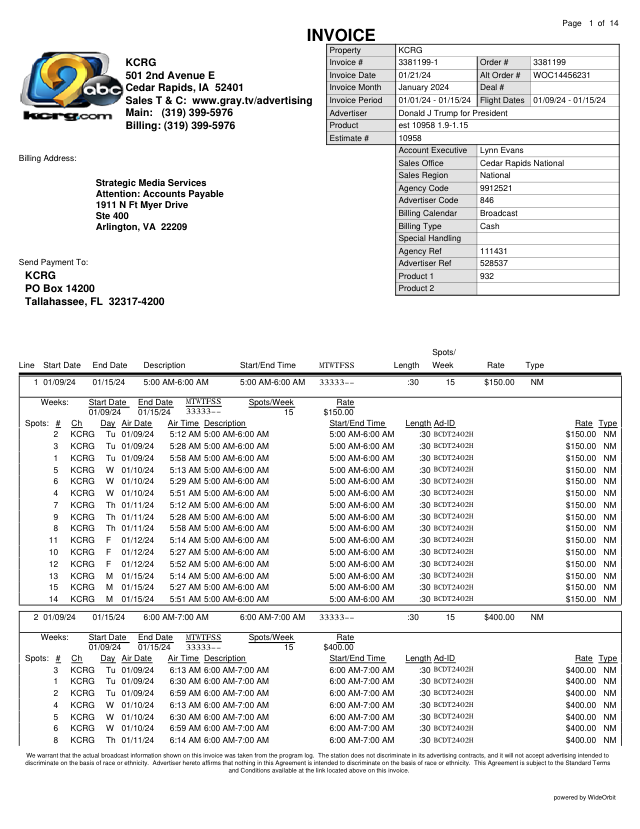

In [65]:

image = show_image_page(bucket_name, blob_path)
image

In [69]:
import pandas as pd
from google.cloud import bigquery

# Assume bq_client and CONNECTION_RESOURCE are configured
# bq_client = bigquery.Client()
# CONNECTION_RESOURCE = "your-project.your-region.your-connection-name"

# 1. The prompt remains the same as requested.
prompt = """
ROLE: You are an automated invoice processing system.
TASK: Analyze the provided invoice image and extract the full name and mailing address for both the Advertiser and the Invoice Issuer.
OUTPUT FORMAT:
- Respond with ONLY a single, valid JSON object.
- The root object should contain two keys: "advertiser" and "invoice_issuer".
- Each key should map to an object with "name" and "address" keys.

EXTRACT ONLY DATA THAT IS PRESENT IN THE PROVIDED TEXT !!!

Example Response:
{
  "advertiser": { "name": "Donald J Trump for President 2024", "address": "PO Box 13570\\nArlington VA 22219" },
  "invoice_issuer": { "name": "WGTU", "address": "851 S. Ellsworth Avenue\\nTraverse City, MI 49686-4554" }
}
"""

# 2. Define the exact GCS location of the text file.
text_file_uri = "gs://trump-political-ads-sample/FCC/docs/0e1877df-6228-022e-9bc0-5f5f5bffacf8/Trump Jan inv KCRG3381199-1/extracted_words.txt"


# 3. The SQL is nearly identical, just using a different parameter name for clarity.
sql = f"""
WITH ai_call AS (
  SELECT
    AI.GENERATE(
      STRUCT(
        @prompt      AS prompt,
        @text_file_uri AS input -- The input is now the text file URI
      ),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => 'gemini-2.5-pro'
    ) AS response
)
SELECT
  -- Return the URI to confirm which file was processed
  '{text_file_uri}' AS file_processed,
  response.result AS json_result
FROM ai_call
"""

# 4. Update the job configuration to pass the new text_file_uri parameter.
job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", prompt),
        bigquery.ScalarQueryParameter("text_file_uri", "STRING", text_file_uri),
    ]
)

# 5. Execute the query and print the result.
df = bq_client.query(sql, job_config=job_cfg).to_dataframe()

print("--- Smoke Test Result ---")
print(df.to_string())

--- Smoke Test Result ---
                                                                                                                  file_processed                                                                                                                                                                                                                                                        json_result
0  gs://trump-political-ads-sample/FCC/docs/0e1877df-6228-022e-9bc0-5f5f5bffacf8/Trump Jan inv KCRG3381199-1/extracted_words.txt  ```json\n{\n  "advertiser": {\n    "name": "TRUMP FOR PRESIDENT 2024, DONALD J",\n    "address": "PO BOX 13570\nARLINGTON, VA 22219"\n  },\n  "invoice_issuer": {\n    "name": "KCRG-TV",\n    "address": "PO Box 8175\nCedar Rapids, IA 52408-8175"\n  }\n}\n```


In [70]:
clean = process_result(df)
clean

{'advertiser': {'name': 'TRUMP FOR PRESIDENT 2024, DONALD J',
  'address': 'PO BOX 13570\nARLINGTON, VA 22219'},
 'invoice_issuer': {'name': 'KCRG-TV',
  'address': 'PO Box 8175\nCedar Rapids, IA 52408-8175'}}

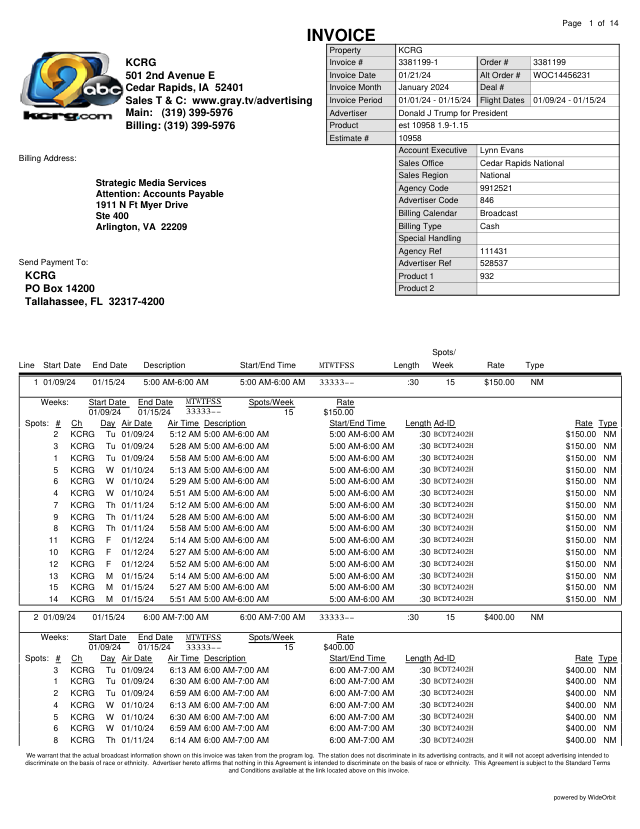

In [68]:
image